<a href="https://colab.research.google.com/github/seonleeuni/mge51101-20205196/blob/master/Final%20project/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Sentiment analysis with Convolutional Neural Network(CNN)
Using SNS comments which consist of very short sentences, we will classify 7 sentiments. This data is from AI hub. The sentences are short, therefore, we will use CNN rather than others like RNN. In this model, we will firstly normalize the sentence(preprocessing), and vectorize the words in each sentence using pre-embedded word dictionary 'ko.wiki' which is trained by fasttext. The principle of CNN to analyze the sentence is that it tokenizes each sentence in a unit that consists of 2, 3, 4 words(2-gram, 3-gram, 4-gram language model) and shrink dimension of embedded sentence using 100 convolutional kernels. After padding each n-gram outputs, we will integrate these outputs together and linear transformation will be done. 

While training, we will choose a model which have best validation accuracy. We will test the model with accuracy and f1 score. However, our model has 7 classes. Therefore, we will check confusion matrix and get precision and recall for each emotion to find out which sentiment the model can predict best.

First, we will call our data from google drive. The data had been downloaded from AI hub site.

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
!apt-get update

!apt-get install g++ openjdk-8-jdk python-dev python3-dev

!pip3 install JPype1-py3

!pip3 install konlpy

!JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-

In [3]:
import pandas as pd
import numpy as np

# Font environment setting for Korean font
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()


path = '/content/gdrive/My Drive/Colab Notebooks/'
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data.csv')
data.head()
data.columns
data.shape[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Selecting previously unselected package fonts-nanum.
(Reading database ... 144832 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


38594

## Data loading and target balance check
Load the data and erase useles colums and check whether there are any null data. There is no null data here. Then, we checked the target emotions are distributed balanced with bar graph. Our data was balanced so that there would be less effect to be classified to one emotion.(It is likely to train evenly)

In [5]:
# Erase useles columns
data = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/sentence.xlsx')
data.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', '공포',5468],axis =1,inplace = True)
data.head()

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포


In [6]:
'''
null data check
'''
print(data.isnull().sum()) # There is no null data

Sentence    0
Emotion     0
dtype: int64


In [7]:
emotion = data.Emotion.unique() #check elements in Emotion
print(emotion)
emotion_E = ['Scared','Surprised','Angry','Sad','Neutral','Happy','Disgusted'] # Names to change Korean to English

for i in range(len(data)):
  for j in range(7):
    if data.Emotion[i] == emotion[j]:
      data.Emotion[i] = emotion_E[j]
    

#data_original.Emotion.unique()
print(data.Emotion.unique())

['공포' '놀람' '분노' '슬픔' '중립' '행복' '혐오']
['Scared' 'Surprised' 'Angry' 'Sad' 'Neutral' 'Happy' 'Disgusted']


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


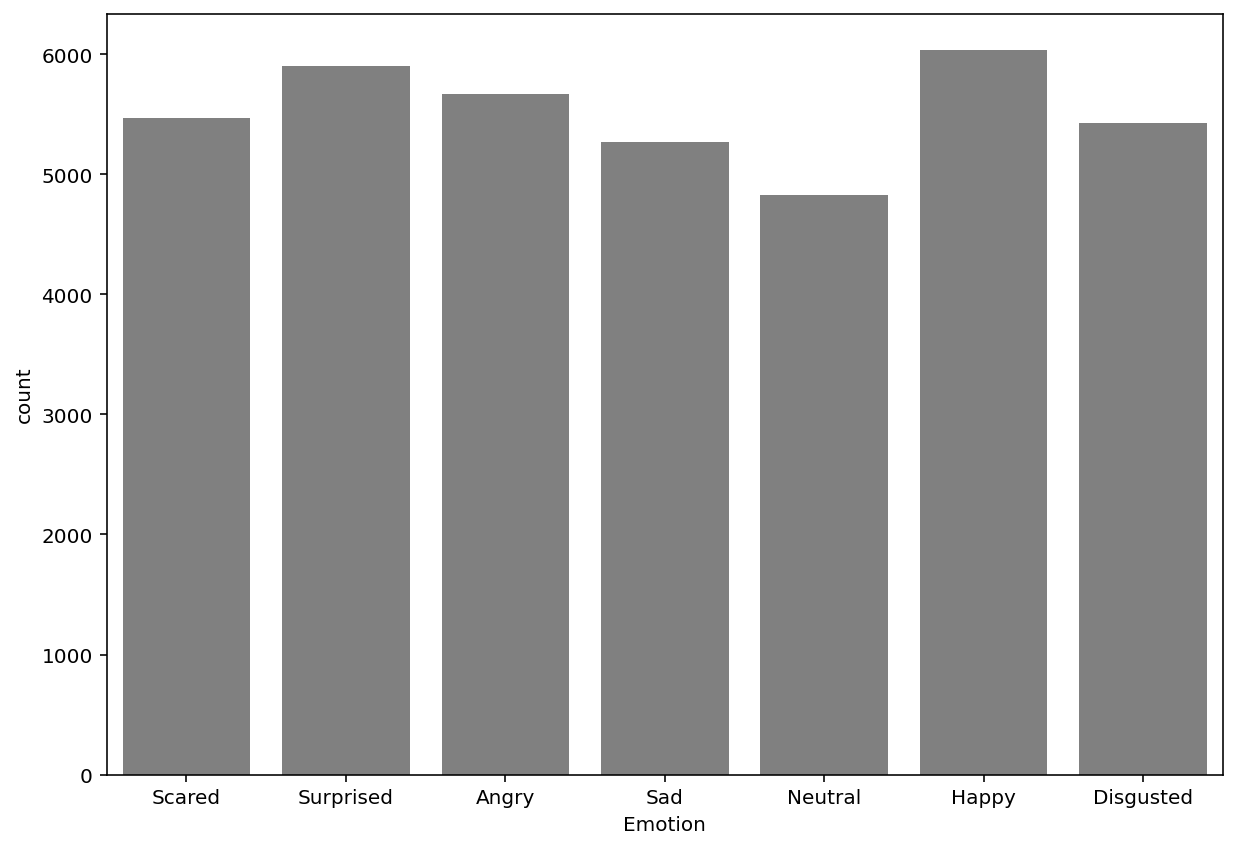

In [8]:
# Check emotion proportion
figure_1 = plt.figure(figsize = (10,7))
sns.countplot(data = data, x = 'Emotion', color = 'grey')
sns.set(font_scale=1.7)
figure_1.savefig('graph1.png')

## Preprocessing
Preprocessin is a process just before vectorization of sentnece. For the preprocessing, there are 3 steps. 


>Cannonicalization

There are many expressions which is not formal one because the sentences are from SNS. Therefore, there are emoticons or typo like single Ja, Mo. We will romove those things first using `re.sub` in this process. We will remove puctuation marks either.

> Tokenization & morphological analyze

Before Embedding, we should do morphological analysis to normalize the Korean words because there are lots of expressions which have same meaning caused by Josa in Korean. Here, we will use `Okt` from `konlpy` for morphological analyzer. `Okt` is  Twitter based morphological analyzer which is specialied to SNS words which have various changes.

> Erase outliers which have over length or less length than standard

Because too short sentence including one or 2 words can affect model to be confused, so we will erase sentences which include less than 3 words. Also, by restricting the length of the sentence as 3 of 4 th length(calculated by `quantile(data.length_n,0.75)`), we matched the dimension of data which will be used for modeling.

In [9]:
import re
'''
Cannonicalization
'''

for i in range(0,data.shape[0]):
    text = data.Sentence[i]
    text = re.sub('[^\w\s]','',text) # remove puctuations and emoticons 
    data.Sentence[i] = re.sub('([ㄱ-ㅎㅏ-ㅣ]+)','',text) # remove Ja Mo here

data.head()

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,Scared
1,그냥 내 느낌일뿐겠지,Scared
2,아직너무초기라서 그런거죠,Scared
3,유치원버스 사고 낫다던데,Scared
4,근데 원래이런거맞나요,Scared


In [10]:
from konlpy.tag import Okt
'''
Tokenization & morphological analyze:
Divide the words from the sentence and change the words into standard morpheme
'''
# morphological analizer for SNS envirionment
Okt = Okt()

# normalizing and sort out just stem because lots of difference of feeling 어감차이

data['mor'] = np.nan
for i in range (0,data.shape[0]):
  data.mor[i] = Okt.morphs(data.Sentence[i], norm = True, stem = True) # Save morphemes in column named mor
data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,Sentence,Emotion,mor
0,언니 동생으로 부르는게 맞는 일인가요,Scared,"[언니, 동생, 으로, 부르다, 맞다, 일, 인가요]"
1,그냥 내 느낌일뿐겠지,Scared,"[그냥, 내, 느낌, 일, 뿐, 겠다]"
2,아직너무초기라서 그런거죠,Scared,"[아직, 너무, 초기, 라서, 그런, 거, 죠]"
3,유치원버스 사고 낫다던데,Scared,"[유치원, 버스, 사고, 낫다]"
4,근데 원래이런거맞나요,Scared,"[근데, 원래, 이렇다, 맞다]"


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Erase stopwords from morpheme set(mor) 

stopword = set(['은','는','이','가','것','거','의','을','를','와','야','께','바'])
data['mor_new'] = np.nan 

for i in range(len(data.mor)):
  r = []
  for w in data.mor[i]: 
    if not w in stopword:
      r.append(w) 
    data.mor_new[i] = r #Save morpheme set without stopwords into column named mor_new 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [12]:
'''
Erase outliers which have over length or less length than 2
:Reason is that length less than 2 is not meaningful in 3 or 4 gram language model
'''

#drop the Sentences which have less than 2 words

# check the length of the words for each sentence
# data.length = number of words in a sentence
data['length_n'] = np.nan
for i in range(len(data.mor_new)):
  data.length_n[i] = len(data.mor_new[i])

data.length_n = data.length_n.astype(int)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


7.819635176452298 10.0


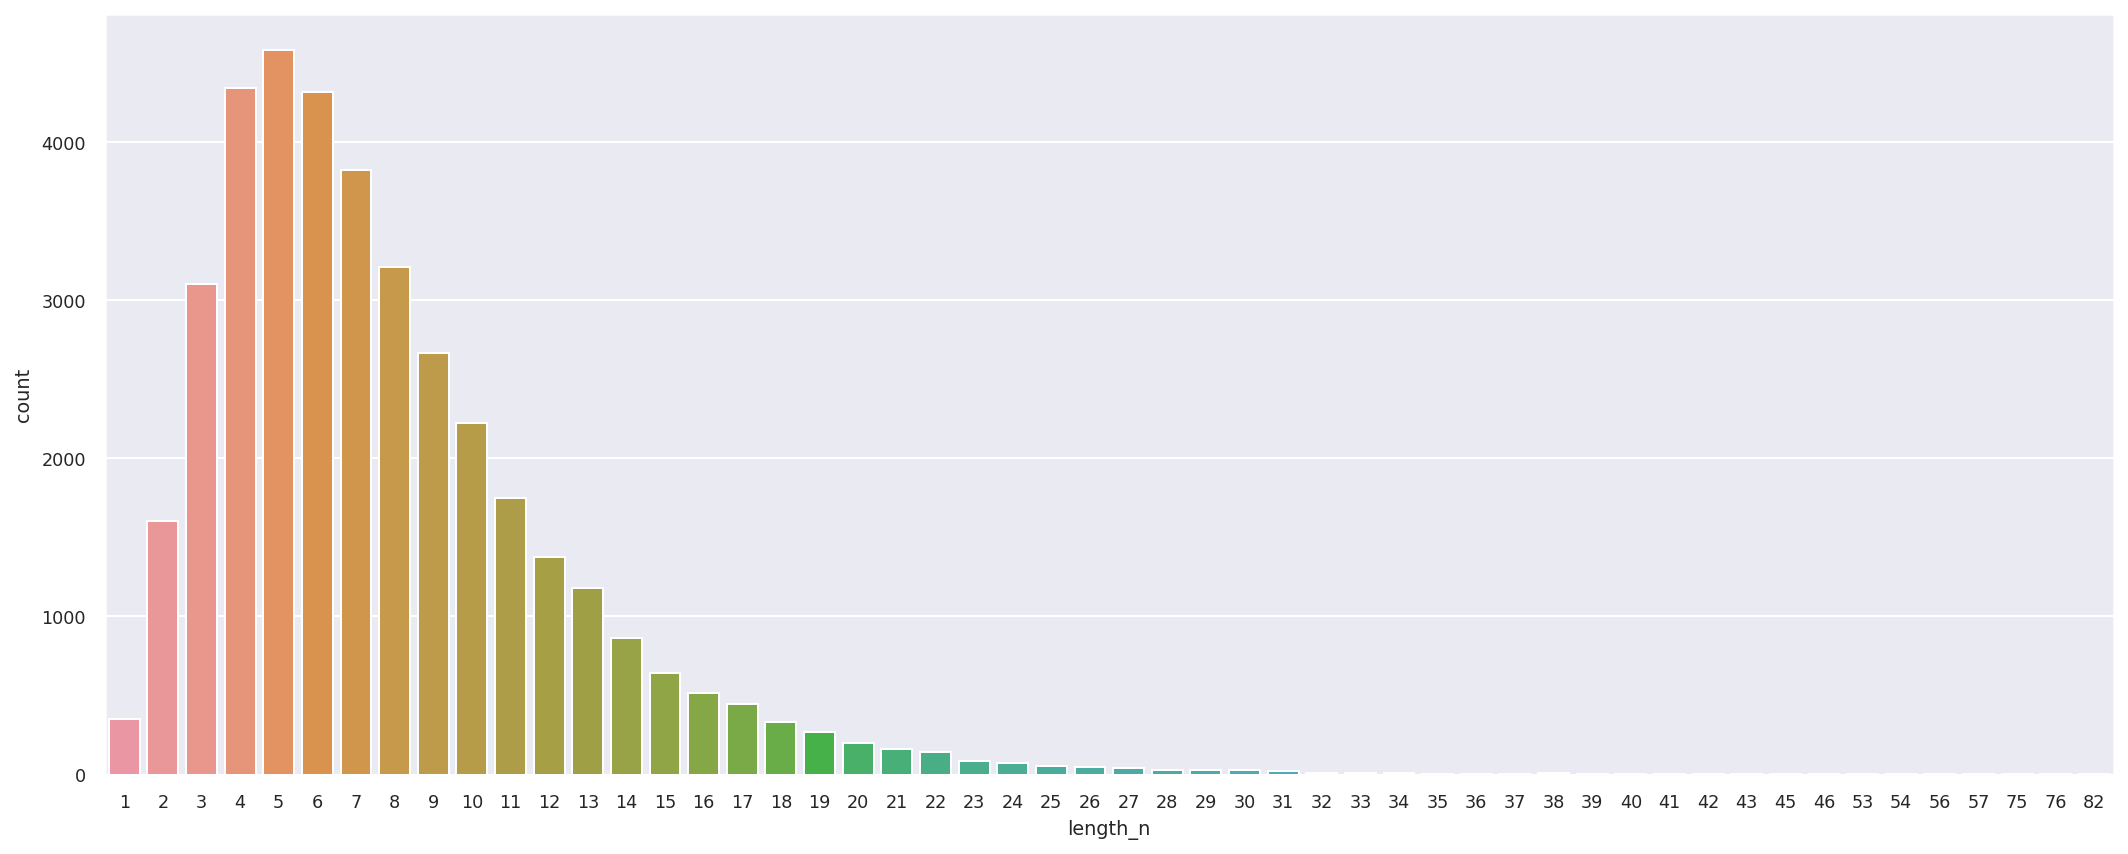

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

#Check the length distribution
plt.figure(figsize = (18,7))
sns.countplot(data= data, x = 'length_n')
sns.set(font_scale = 0.8)
print(np.mean(data.length_n), np.quantile(data.length_n,0.75))

In [ ]:
data_new = data.drop(index = data[data.length_n<3].index,axis = 0) # drop sentences which have less than 2 words and save it in new dataframe, 'data_new'

In [ ]:
# Check how many sentences were erased
print('number of erased rows is ', data.shape[0]-data_new.shape[0])

# Check whether the distribution of emotions were changed
a = data_new.Emotion.value_counts()
print(round(a/sum(a),2))
print('Emotion has still balanced and been changed very little')

number of erased rows is  1960
Angry        0.15
Happy        0.15
Surprised    0.15
Disgusted    0.15
Scared       0.14
Sad          0.13
Neutral      0.13
Name: Emotion, dtype: float64
Emotion has still balanced and been changed very little


This is end of the preprocessing and the Sentence and Emotion cab be shown below,



In [ ]:
data_new = data_new[['Sentence','Emotion']] # Extract Sentence and emotion only for model training

data_new.head()

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요,Scared
1,그냥 내 느낌일뿐겠지,Scared
2,아직너무초기라서 그런거죠,Scared
3,유치원버스 사고 낫다던데,Scared
4,근데 원래이런거맞나요,Scared


## Split data into training, validation, testing set
To train the data and test the model, we have to divide our data into 3, each for training, validation, and testing. Validation set is needed to prevent overfitting. We will use validation set when training the model and save the model with highest validation accuracy in all epoches. The proportion would be 6:2:2. This would be divided using `train_test_split` . The training, validation, testing sets should be saved to be used for machine learning models to compare the performance.


In [ ]:
# train:valid:test = 6:2:2 (seperating dataset)

from sklearn.model_selection import train_test_split

for i in range(7):
  if i == 0:
    X = data_new[data_new.Emotion==emotion_E[i]]#.mor_new, data_new[data_new[Emotion[i]]==1][Emotion]
    train, test = train_test_split(X, test_size=0.2)
    train, valid = train_test_split(train, test_size = 0.25)
  else:
    X = data_new[data_new.Emotion==emotion_E[i]]#.mor_new, data_new[data_new[Emotion[i]]==1][Emotion]
    train_, test_ = train_test_split(X, test_size=0.2)
    train_, valid_ = train_test_split(train_, test_size = 0.25)
    train = train.append(train_)
    valid = valid.append(valid_)
    test = test.append(test_)
   


In [ ]:
#Save dataset as csv file for other machine learning models for model performance comparison

print(train.shape[0],valid.shape[0],test.shape[0],'sum',train.shape[0]+test.shape[0] + valid.shape[0])
train.head()

train.to_csv('train.csv')
!cp train.csv "gdrive/My Drive/Colab Notebooks"

test.to_csv('test.csv')
!cp test.csv "gdrive/My Drive/Colab Notebooks"

valid.to_csv('valid.csv')
!cp valid.csv "gdrive/My Drive/Colab Notebooks"

21977 7327 7330 sum 36634


## Change data to torchtext
Before tranining, we need to change our data type to torchtext. We will use the csv file that we just saved, and make `Field` to call the data. We will divide TEXT field for sentece and LABEL field for emotion. 

Setting the TEXT field, we will set `sequential = True`  to notice that this data is sequential. In the case of LABEL field, `sequential = False`, which menas it is not need to tokenize the data. Then, we will use Korean morphological analyzer `Okt` to tokenize the sentence into words in both TEXT and LABEL field. For tokenizing in TEXT field, we set the stopwords. We will set first dimension as batch dimension, so set `batch_first = True`. We will fix the length to 10, because from the above graph cut the sentences which have more than 10 which is three forth point in distribution of sentence length.
In the case of LABEL field, set `is_target = True`, and unk_token = None to erase <unk> element.




In [17]:
from torchtext.data import Field

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from konlpy.tag import Okt


'''
Changing pandas dataframe to torchtext 
'''

tokenize = lambda x: Okt.morphs(x, norm = True, stem = True) # Using Korean morphological analyzer as tokenizer
stopword = set(['은','는','이','가','것','거','의','을','를','와','야','께','바']) # Stop words list: Erase stopwords

# Make field to change datafrmae to torch text with above tokenizer and stopwords 
TEXT = Field(sequential=True,
            use_vocab=True, # This is for embedding so that sentences will be vecotrized
            tokenize=tokenize, 
            stop_words = stopword,
            batch_first=True,
            fix_length=10) # Erase outliers which have more than 10 words

LABEL = Field(sequential=False, use_vocab=True, is_target=True, unk_token = None) 

In [18]:
# change into torch data

from torchtext.data import TabularDataset

datafields = [ # id is not needed, so we pass in None as the field
                 ('Unnamed: 0', None),("Sentence", TEXT),("Emotion", LABEL)
                 ]
trn, val, tst = TabularDataset.splits(
               path="/content/gdrive/My Drive/Colab Notebooks", # the root directory where the data lies
               train='train.csv', validation = "valid.csv", test="test.csv",
               format='csv',
               skip_header=True, # this csv file does not have header
               fields=datafields)


Check whether each trn, val, tst has appropriate dataset. Also, check the number of data in each groups.


In [19]:
print(vars(trn[1]))
print(vars(val[1]))
print(vars(val[1]))

{'Sentence': ['제', '민감하다', '가요'], 'Emotion': 'Scared'}
{'Sentence': ['게', '될런', '지', '모르겄', '지만'], 'Emotion': 'Scared'}
{'Sentence': ['게', '될런', '지', '모르겄', '지만'], 'Emotion': 'Scared'}


In [20]:
print('number of train : {}'.format(len(trn)))
print('number of test : {}'.format(len(tst)))
print('number of valid : {}'.format(len(val)))

number of train : 21977
number of test : 7330
number of valid : 7327


## Embedding
First, call for pretrained words with embedded vectors by fasttext using skip-gram described in Bojanowski et al. (2016), 'wiki.ko.vec'. It had been pretrained with fasttext and its data is from website wiki. The word vectors have 300 length. 

We will use this pretrained word dictionary for embedding. Before doing embedding, we will make word vocabulary dictionary of our training data set using `build_vocab`.

In [21]:
# call for pretrained words with embedded vectors from fasttext. 
# 
# word vectors in wiki.ko.vec have 300 length
import torchtext
vector = torchtext.vocab.Vectors('wiki.ko.vec', cache=path)

In [22]:
import torch
MAX_VOCAB_SIZE = 25000

# build_vocab make each words in sentence to vectors from Korean pretrained words dictionary with fasttext.
TEXT.build_vocab(trn, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = vector, 
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(trn)

In [23]:
print('단어 집합의 크기 : {}'.format(len(TEXT.vocab)))

단어 집합의 크기 : 18252


In [24]:
print(TEXT.vocab.stoi)
print(LABEL.vocab.stoi)

defaultdict(<function _default_unk_index at 0x7f9344dffea0>, {'<unk>': 0, '<pad>': 1, '하다': 2, '에': 3, '들': 4, '도': 5, '있다': 6, '보다': 7, '되다': 8, '다': 9, '아니다': 10, '없다': 11, '이다': 12, '같다': 13, '안': 14, '으로': 15, '진짜': 16, '에서': 17, '한': 18, '너무': 19, '못': 20, '로': 21, '저': 22, '요': 23, '사람': 24, '만': 25, '좋다': 26, '고': 27, '나': 28, '아': 29, '가다': 30, '오다': 31, '그': 32, '왜': 33, '받다': 34, '않다': 35, '그렇다': 36, '네': 37, '들다': 38, '하고': 39, '말': 40, '더': 41, '정말': 42, '제': 43, '게': 44, '어떻다': 45, '먹다': 46, '나오다': 47, '때': 48, '알다': 49, '생각': 50, '모르다': 51, '인데': 52, '내': 53, '라': 54, '잘': 55, '하': 56, '뭐': 57, '많다': 58, '국민': 59, '좀': 60, '일': 61, '까지': 62, '인': 63, '돈': 64, '나라': 65, '지': 66, '지금': 67, '그냥': 68, '적': 69, '이렇다': 70, '니': 71, '개': 72, '면': 73, '많이': 74, '과': 75, '한테': 76, '자다': 77, '님': 78, '맞다': 79, '이제': 80, '해주다': 81, '나다': 82, '안되다': 83, '우리': 84, '근데': 85, '부터': 86, '서': 87, '오늘': 88, '대통령': 89, '0': 90, '수': 91, '이나': 92, '랑': 93, '싶다': 94, '또': 95, '놈': 96, '주다': 9

## Prepare mini batches for modeling
To train the model, we set batch size and make iterator to be used for models. we will set batch size as 50, and after dividing the batches, we confirm whether mini batches were divided well. 

In [89]:
from torchtext.data import BucketIterator

# make mini batches to use in training

batch_size = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # device to set runtime as GPU rather CPU

train_loader, valid_loader, test_loader = BucketIterator.splits(
    (trn, val, tst),
    batch_size = batch_size, 
    device = device, sort = False) 

In [90]:
print('mini batch of train : {}'.format(len(train_loader)))
print('mini batch of valid : {}'.format(len(test_loader)))
print('mini batch of test : {}'.format(len(test_loader)))

mini batch of train : 440
mini batch of valid : 147
mini batch of test : 147


In [91]:
#Batch consists of Sentence & Emotion
batch = next(iter(test_loader)) # First mini batch
print(batch.Emotion)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4])


## Make CNN model
We will make the model to train our data. Firstly, the preprocessed sentences which are tokenized will be embedded by `torch.nn.Embedding` with word dictionary that we made above.(`TEXT.vocab.stoi[TEXT.pad_token]`) Then, we will make a new dimension for adjust `in_channel = 1` for convolution by `unsqueeze(1)`.
Then, the dimension of the input data would be, **[batch size, 1, sent len, emb dim]**.

Using this, we will undergo CNN process. The structure is shown briefly in the below figure.

![](https://docs.google.com/uc?export=download&id=1b-ddiGUQ2EjGiTkaDIGoiPk3OgfjxfMn)

we will do 3 convolutions, of which kernel size is (2,300), (3,300), (4,300) which indicates 2, 3, 4 gram so that the output would be size in **[batch size, n_filters, sentence length - filter_sizes[n]+1,1]**. Here, we used `relu` as activation function. We will remove 4th dimension with size 1 with `squeeze(3)` to erase unexpected error. 

Because we want extract the maximum element which affects sentence most, we will use `max_pool1d` with same size with outcome of convolutions **sentence length - filter_sizes[n]+1**. And shrink dimension again which make dimension to be **[batch size, n_filters]**. 

Using `cat`, integrate the 2, 3, 4 gram outcomes and then do full connection of this using linear transformation. The output has 7 values.

In this process, before doing linear transformation, we do regularization using `Dropout` funtion. We will drop less than 0.4 values to remove noise. It means that if there are too many detailed information in the final steps, the model can be confused by weak signals. This can lead overfitting, so we put `Dropout` function before linear tranformation.


In [75]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx) # Embedding with fasttext word vocabulary dictionary-->we will use Text.vocab(from kor.fasttext) (vocabulary size of the sentence, same with word vector dim=300)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, sentence):
        
        #batch.Sentence = [batch size, sent len]
        
        embedded = self.embedding(sentence)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1) 
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs] # tensor has 4th dimension of size 1, so preventing unexpected error, remove the batch dimension.
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]+1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved] # tensor has 4th dimension of size 1 from the same reason above.
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [92]:
# set parameters

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300 # Because word vector has 300 dimension
N_FILTERS = 100 
FILTER_SIZES = [2,3,4] #[2-grams, 3-grams, 4-grams]
OUTPUT_DIM = len(LABEL.vocab)
DROPOUT = 0.4
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

## Make unknown and padding tokens to be zero
There are unknown and padding tokens. They don't have any values in embedding vectors, therefore, we will fill their embedding values to be zero.

In [93]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

## Set optimizer and criterion for model selection
We will use Adam optimizer for deep learning model and set criterion to calculate loss. 

In [94]:
import torch.optim as optim
# Use Adam optimizer in training
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

# Set learntime to GPU
model = model.to(device) 
criterion = criterion.to(device)

## Calculation of accuracy function
We will define a function to calculate accuracy. Here, we will firstly get predicted values using `argmax` which extract maximum index. Then, we will extract the values which is same with true y using `eq` from predicted ones. Then this function returns the `correct.sum()`/total size of y which means accuracy.

In [95]:
def categorical_accuracy(preds, y):
    
    # Returns accuracy per batch
    
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    correct = max_preds.squeeze(1).eq(y)
    return correct.sum() / torch.FloatTensor([y.shape[0]])

## Training function
Using gradient discent by `optimizer`, we will keep train our model. Then put the input batch into model and save the outputs. Then using `criterion`, we will calculate the loss and using `categorical_accuracy`, calculate the accuracy for the batch. Then, using `loss.backward()` do backpropagation to train the model. This function returns average accuracy and loss of all batches in iterator.

In [96]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.Sentence)
        
        loss = criterion(predictions, batch.Emotion)
        
        acc = categorical_accuracy(predictions, batch.Emotion)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## Evaluate function
Set evaluate function for evaluation in training and also testing. In the training step, it is used to get validation accuracy and loss. This is almost same with training function above. However, for the sake of getting predicted sentiment values, we get `torch.max(predictions, 1).indices` values and change the predicted value and true value into type `list()`. Therefore, predicted sentiment and true sentiment values are added to the outcome of the function. 

In [97]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    final_y_pred = []
    final_y_true = []
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.Sentence)
            
            y_pred = torch.max(predictions, 1).indices # predicted value

            y_pred = y_pred.tolist() 
       
            y_true = batch.Emotion.tolist()
        
            loss = criterion(predictions, batch.Emotion)
            
            acc = categorical_accuracy(predictions, batch.Emotion)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            final_y_pred = final_y_pred + y_pred # Predicted value
            final_y_true = final_y_true + y_true # Actual value
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), final_y_pred, final_y_true

## Time function
Time function is used to check time how many times 1 epoch takes. 

In [98]:
# function to measure time
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Training section
At the starting point of the epoch, record starting time with `time.time()`. Then, using the above `train` and `evaluate` functions, we will train our model. By  `time.time()` again, record ending time. All the accuracy and loss of training and validation set are recorded in `accuracy_graph`, and `loss_graph` to visualize how model learned in each epoch. Training the model, we will choose a model which have maximum validation accuracy among all epochs. We can save the model by `torch.save(model.state_dict(), 'tut5-model.pt')`. Then, visualize variation of loss and accuracy while training.

In [99]:
accuracy_graph = {'train':[], 'test':[], 'epoch': []}
loss_graph = {'train':[], 'test':[], 'epoch': []}

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    valid_loss, valid_acc, y_p, y_t = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    # Save the train,test loss and accuracy for each epoch
    accuracy_graph['train'].append(train_acc)
    accuracy_graph['test'].append(valid_acc) 
    accuracy_graph['epoch'].append(epoch)
    loss_graph['train'].append(train_loss)
    loss_graph['test'].append(valid_loss)
    loss_graph['epoch'].append(epoch)

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # save model when the model has best validation accuracy
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt') #save model as 'tut5-model.pt'
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t valid. Loss: {valid_loss:.3f} |  valid. Acc: {valid_acc*100:.2f}%')
  

Epoch: 01 | Epoch Time: 0m 48s
	Train Loss: 1.809 | Train Acc: 28.00%
	 valid. Loss: 1.634 |  valid. Acc: 35.03%
Epoch: 02 | Epoch Time: 0m 45s
	Train Loss: 1.490 | Train Acc: 43.13%
	 valid. Loss: 1.631 |  valid. Acc: 36.32%
Epoch: 03 | Epoch Time: 0m 45s
	Train Loss: 1.262 | Train Acc: 52.61%
	 valid. Loss: 1.617 |  valid. Acc: 38.50%
Epoch: 04 | Epoch Time: 0m 45s
	Train Loss: 1.037 | Train Acc: 62.13%
	 valid. Loss: 1.703 |  valid. Acc: 37.97%
Epoch: 05 | Epoch Time: 0m 46s
	Train Loss: 0.828 | Train Acc: 70.22%
	 valid. Loss: 1.872 |  valid. Acc: 37.82%
Epoch: 06 | Epoch Time: 0m 45s
	Train Loss: 0.652 | Train Acc: 76.80%
	 valid. Loss: 2.025 |  valid. Acc: 38.30%
Epoch: 07 | Epoch Time: 0m 45s
	Train Loss: 0.517 | Train Acc: 81.60%
	 valid. Loss: 2.174 |  valid. Acc: 38.12%
Epoch: 08 | Epoch Time: 0m 45s
	Train Loss: 0.423 | Train Acc: 84.91%
	 valid. Loss: 2.325 |  valid. Acc: 38.33%
Epoch: 09 | Epoch Time: 0m 45s
	Train Loss: 0.333 | Train Acc: 88.16%
	 valid. Loss: 2.524 |  va

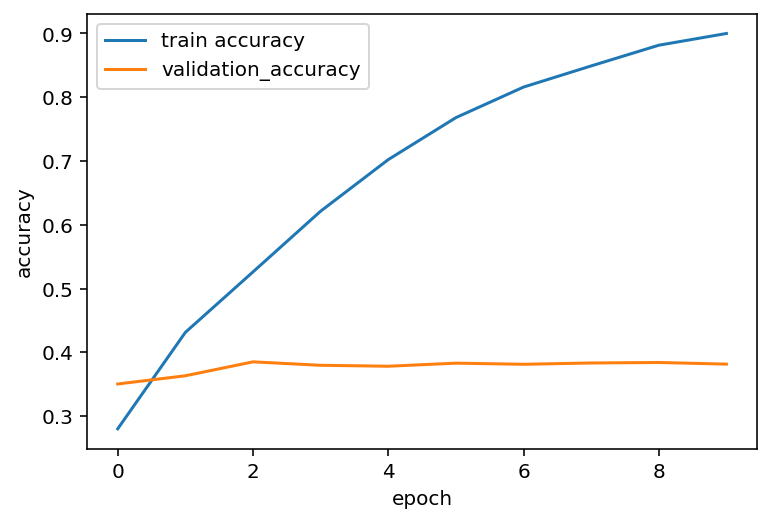

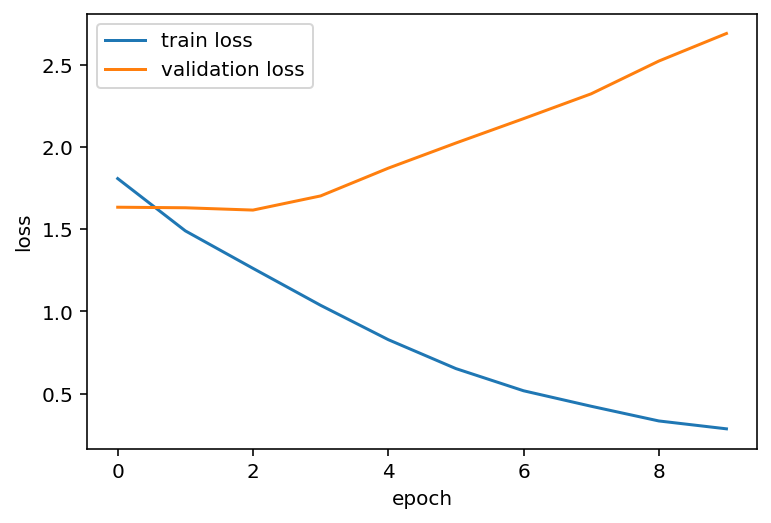

In [103]:
# Plot loss curve
figure= plt.figure()
plt.plot(accuracy_graph['epoch'], accuracy_graph['train'], label = "train accuracy");
plt.plot(accuracy_graph['epoch'], accuracy_graph['test'], label = "validation_accuracy");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.show()
figure.savefig('accuracy.png')

figure_3 = plt.figure()
plot_loss_train = plt.plot(loss_graph['epoch'], loss_graph['train'], label="train loss");
plt.plot(loss_graph['epoch'], loss_graph['test'], label="validation loss");
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()
figure_3.savefig('loss.png')

## Testing
Using `evaluate` function, get test accuracy and f1-score. When calculating f1-score, we used 'weighted' average to calculate metrics for every label, and find their average weighted by the number of true instances for each label.

In [107]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as sk

model.load_state_dict(torch.load('tut5-model.pt'))

test_loss, test_acc, pre, true = evaluate(model, test_loader, criterion)
f1_score = sk.f1_score(true,pre, average = 'weighted') # calculate f1_score for all batches with average = 'micro'
        

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | F1_socre: {f1_score:.2f}')

Test Loss: 1.647 | Test Acc: 37.13% | F1_socre: 0.37


## Measuring performance of model with accuracy, f1-score using confusion matrix
Firstly, to get recall and precision for each sentiment, we need to get confusion matrix thorugh `confusion_matrix`. Then, we will make 3 bins to get the calculated values of recall, precision and f1 score each. From the confusion matrix, calculate each values. AFter that, we will concate the three bins togather as type of `pd.DataFrame`. Finally, we will put labels for each element again, according to the `LABEL` word dictionary.

In [106]:
con=confusion_matrix(true, pre) # row indicates actual emotion, column indicates predicted emotion

recall_sentiment = [] 
precision_sentiment = []
f1 = []
for i in range(7):
  a = con[i,i]/sum(con[i,:])
  recall_sentiment.append(a)
  b = con[i,i]/sum(con[:,i])
  precision_sentiment.append(b)
  f1.append(2*(a*b)/(a+b))

sentiment = pd.DataFrame([recall_sentiment,precision_sentiment,f1])

# Same as LABEL word sequence ['Angry': 0, 'Happy': 1, 'Surprised': 2, 'Disgusted': 3, 'Scared': 4, 'Sad': 5, 'Neutral': 6]
label = ['Angry', 'Happy', 'Surprised', 'Disgusted', 'Scared', 'Sad', 'Neutral']

sentiment.columns = label
sentiment.index = ['Recall','Precision','F1-score']

sentiment.round(2)


,Angry,Happy,Surprised,Disgusted,Scared,Sad,Neutral
Recall,0.39,0.63,0.22,0.30,0.35,0.50,0.20
Precision,0.35,0.57,0.43,0.28,0.39,0.36,0.21
F1-score,0.37,0.60,0.29,0.29,0.37,0.42,0.20
